## Import necessary packages 

distance() function allows you to compute the distance of any two Cartesian points in the 2D plane

In [1]:
import glob, os
import csv
import numpy as np
import matplotlib.pyplot as plt
import math

def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

#import more packages
import torch
import torch.nn as nn
from torch.autograd import Variable

## Preprocess data, stored as .txt files in the dataset/ folder

In [2]:
#In this PREPROCESS, whenever Concorde chooses to branch on an edge with a zero LP value, we omit that data point

#path of the directory containing data
path = "./dataset/"
dirs = os.listdir(path)

#number of Files in the dataset/ directory
numFiles = 5696 #had to remove some data that had I/O issues
#initial number of columns of my np matrix containing the data
numColsY = 50
numColsX = 5*numColsY

#TESTING: Smaller Dataset
#numFiles = 100

#instantiate matrices to hold preprocessed data
Xall = np.zeros(shape=(numFiles, numColsX))
tempvec = np.zeros(shape=(numFiles, numColsY))
Yall = np.zeros(shape=(numFiles, 1))


index = 0
for file in dirs[:numFiles]:
    fname = "./dataset/" + file
    #get (X,Y) coordinates of each city of the TSP
    coords = np.genfromtxt(fname=fname, skip_header=6,max_rows=50,
                       usecols=(1,2))
    
    internal = coords[0,:]
    
    #Get the LP value of nonzero edges 
    data = np.genfromtxt(fname=fname, skip_header=58,usecols=(0,1,2))
    X = np.zeros(shape=data[:,2].shape[0]*5)
    Y = np.zeros(shape=data[:,2].shape)
    #Target is the edge Concorde decided to branch on
    #Edge is represented as a (fr, to) tuple, where fr is the outgoing 
    #city and to is the receiving city
    target = np.genfromtxt(fname=fname, skip_header=56,
                           max_rows=1,usecols=(0,1))
    target = [int(x) for x in target]

    #Y contains all 0s except for that edge selected by Concorde to branch on.
    #that one singular edge is set to 1
    #X contains all edges distances multiplied by their corresponding LP value
    for i, num in enumerate(Y):
        fr = (coords[int(data[i,0]), 0]-internal[0], coords[int(data[i,0]), 1]-internal[1])
        to = (coords[int(data[i,1]), 0]-internal[0], coords[int(data[i,1]), 1]-internal[1])
        X[5*i] = fr[0]
        X[5*i + 1] = fr[1]
        X[5*i + 2] = to[0]
        X[5*i + 3] = to[1]
        X[5*i + 4] = data[i, 2]
        if target[0] == data[i, 0] and target[1] == data[i, 1]:
            Y[i] = 1
        elif target[1] == data[i, 0] and target[0] == data[i, 1]:
            Y[i] = 1
    
    #if np.count_nonzero(Y) == 0:
    #    print("DEBUG", index)
    
    #The following four if statements take care of zero-padding
    #so that all vectors are of the same size
    if X.shape[0] > numColsX:
        z = np.zeros((numFiles, X.shape[0] - numColsX))
        Xall = np.concatenate((Xall,z), axis=1)
        numColsX = X.shape[0]
    
    if X.shape[0] < numColsX:
        z = np.zeros((1, numColsX - X.shape[0]))
        z=z[0]
        X = np.concatenate((X, z))
        
    if Y.shape[0] > numColsY:
        z = np.zeros((numFiles, Y.shape[0] - numColsY))
        tempvec = np.concatenate((tempvec,z), axis=1)
        numColsY = Y.shape[0]
    
    if Y.shape[0] < numColsY:
        z = np.zeros((1, numColsY - Y.shape[0]))
        z=z[0]
        Y = np.concatenate((Y, z))
        
    #if np.count_nonzero(Y) == 0:
    #    print("DEBUG", index)
    
    Xall[index,:] = X
    tempvec[index,:] = Y
      
    index = index + 1

#Filter out matrices with all zeros; in those instances, Concorde chose to branch on an edge with LP value of 0
Xall = Xall[~np.all(tempvec == 0, axis=1)]
tempvec = tempvec[~np.all(tempvec == 0, axis=1)]

Yall = np.argmax(tempvec, axis=1)
X = Xall
y = Yall

In [3]:
tempvec.shape

(4863, 78)

## Define Neural Network

In [4]:
class My_Neural_Net(nn.Module):
    def __init__(self, X):
        super(My_Neural_Net, self).__init__()
        
        X_dim = X.shape[1]
        numEdgeCandidates = tempvec.shape[1]
        
        
        # Define the layers. This matches the image above 
        # Except that our input size is 1000 dimensions
        self.layer_1 = nn.Linear(X_dim, 500)
        self.layer_2 = nn.Linear(500, 500)
        self.layer_3 = nn.Linear(500, numEdgeCandidates) 
        
        # Define activation functions.
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
        #Choose Adam as the optimization method
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        
#1. input X
    def forward(self, X):
        # 2. linearly transform X into hidden data 1 via weights
        X = self.layer_1(X)
        # 3. perform ReLU on hidden data
        X = self.relu(X)
        # 4. linearly transform hidden data into hidden data 2 via weights
        X = self.layer_2(X)
        # 5. perform ReLU on hidden data
        X = self.relu(X)
        # 6. linearly transform hidden data into output layer via weights
        X = self.layer_3(X)
        # 7. perform sigmoid on output data to get f(X) predictions between 0 and 1
        X = self.softmax(X)
        
        # 8. output predictions
        return X
    
    def loss(self, pred, true):
        #PyTorch's own cross entropy loss function.
        score = nn.CrossEntropyLoss()
        return score(pred, true)
    
    # 1. input: N - number of iterations to train, X - data, y - target
    def fit(self,X,y, X_test, y_test, N = 1000):
        
        #first column is epoch/second column is loss
        #third column is accuracy
        #fourth column is loss for test
        #fifth column is loss for test
        losses = np.zeros(shape=(N,5))
        
        # 2. for n going from 0 to N -1 :
        for epoch in range(N):
                      
            # Reset weights in case they are set for some reason
            self.optimizer.zero_grad()
            
            # 3. f(X) = forward(X) 
            pred = self.forward(X)
            
            # 4. l = loss(f(X),y)
            l = self.loss(pred, y)
            acc = (torch.argmax(pred, dim=1) == y).float().mean()
            
            pred_test = self.forward(X_test)
            l_test = self.loss(pred_test, y_test)
            acc_test = (torch.argmax(pred_test, dim=1) == y_test).float().mean()
            
            #print loss
            #print(l.data)
            losses[epoch, 0] = epoch
            losses[epoch, 1] = l.data
            losses[epoch, 2] = acc
            losses[epoch, 3] = l_test.data
            losses[epoch, 4] = acc_test
            
            # 5. Back progation
            l.backward()
            # 5. Gradient Descent
            self.optimizer.step()
        
        return losses
        
    #From a list of a "metric" encoded for each edge (e.g., the distance multiplied by LP value)
    #predict_distribution gives the likelihood of each edge being the successful branching node
    def predict_distribution(self, X):
        distributions = self.forward(X)
                
        return distributions
    
    #This returns the index of the most probable successful branching node from the list of edges
    def predict(self, X):
        probs = self.predict_distribution(X)
        
        return torch.argmax(probs, dim=1)
           
    #Checks how often the most probable successful branching node predicted by DNN is the same
    #as the branching decision made by Concorde TSP Solver
    def score(self, X, y):
        # proportion of times where we're correct
        acc = (self.predict(X) == y).float().mean()
        
        return acc

## Split Dataset into train and test and train on DNN

In [5]:
# Split into train and test so we can fit on some data and see performance 
# on data we havent seen yet.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Turn X and y (train and test) into PyTorch objects. We always have to do this step
X_train_tens = Variable(torch.Tensor(X_train).float())
X_test_tens = Variable(torch.Tensor(X_test).float())
y_train_tens = Variable(torch.Tensor(y_train).long())
y_test_tens = Variable(torch.Tensor(y_test).long())

neur_net = My_Neural_Net(X_train_tens)
losses = neur_net.fit(X_train_tens, y_train_tens,X_test_tens, y_test_tens, N=1000)


## Plot training results and  get final test/train accuracies

score for test data:  tensor(0.4729)
score for train data:  tensor(0.6671)


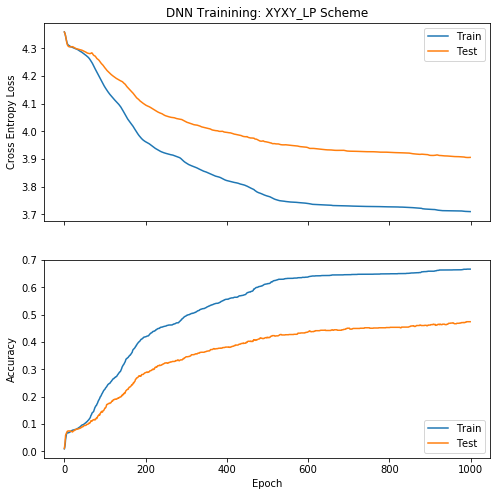

In [6]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True, figsize=(8,8))
axarr[0].plot(losses[:,0], losses[:,1], label='Train')
axarr[0].plot(losses[:,0], losses[:,3], label='Test')
axarr[0].set_ylabel("Cross Entropy Loss")
axarr[0].legend(loc="upper right")
axarr[0].set_title("DNN Trainining: XYXY_LP Scheme")
axarr[1].plot(losses[:,0], losses[:,2],label='Train')
axarr[1].plot(losses[:,0], losses[:,4], label='Test')
axarr[1].set_ylabel("Accuracy")
axarr[1].set_xlabel("Epoch")
axarr[1].legend(loc="lower right")

print("score for test data: ", neur_net.score(X_test_tens,y_test_tens))
print("score for train data: ", neur_net.score(X_train_tens,y_train_tens))




In [7]:
np.savetxt("XYXYLP.csv", losses, delimiter=",")

In [ ]:
import time
start = time.time()
"the code you want to test stays here"
end = time.time()
time_per_query = (end - start) / 100
print(str(time_per_query) + "s" )